In [1]:
from api_call import *
service = get_gmail_service()

get_all_emails_and_save_as_json(service)

Total number of messages: 2100


Processing emails:   7%|▋         | 157/2100 [00:25<06:15,  5.18it/s]

KeyboardInterrupt: 

In [4]:
import re
import json

# helper function to extract email addresses from string
def extract_email_addresses(str):
    email_pattern = re.compile(r'<([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)>')
    emails = email_pattern.findall(str)
    # if no email address was found, return the original string
    if len(emails) == 0:
        return str
    return emails[0]

candidates_and_emails = '../data/Candidates_Emails.json'
with open(candidates_and_emails, 'r', encoding='utf-8') as email_book:
    candidate_email_dict = json.load(email_book)

# Create an empty dictionary
email_content_dict = {}
emails_all = []
with open('../data/emails_extracted.json', 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

# Iterate through all emails
for email in emails_all:
    # Use email address as key and content as value
    if extract_email_addresses(email['from']) not in email_content_dict:
        email_content_dict[extract_email_addresses(email['from'])] = []
    email_content_dict[extract_email_addresses(email['from'])].append(email['content_plain'])

email_content_dict

{'info@email.bobcasey.com': ['Bob Casey for Senate Hi Jenga, The map is looking great! With names from Crawford County to Chester County, Beaver County to Bucks County, folks are stepping up and proving supporters from all across the Commonwealth are ready to re-elect Bob Casey. If you want to be a part of this team of supporters, chip in $5 or whatever you can to get your name on the map! Get on the map We have a lot of maps here at Bob Casey HQ, but this one might be our favorite. In 2020, Bob spent a week in front of his map of Pennsylvania breaking down the election. The stakes were high, and Bob used his expertise to help shed some light on what was happening. Then in 2022, Bob got out his map again to help keep track of the vote count in our Senate and Gubernatorial races until they were called for Senator Fetterman and Governor Shapiro. In 2024, were using our map to show just how many people are with us as we work day in and day out to re-elect Bob to fight for us in the Senate

In [21]:
import os
from bs4 import BeautifulSoup, Comment

json_file_path = '../data/emails_extracted.json'
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

output_text_file_path = '../data/email_contents_plain.txt'
if os.path.exists(output_text_file_path):
    os.remove(output_text_file_path)  # Remove the file if it already exists

# Process the mbox and write email contents to a text file
for detail in emails_all:
    with open(output_text_file_path, 'a', encoding='utf-8') as file:
        if detail['content_plain']:
            # remove empty lines
            detail['content_plain'] = '\n'.join([line for line in detail['content_plain'].split('\n') if line.strip() != ''])
            file.write(detail['content_plain'] + '\n\n')
        # if detail['content_html']:
        #     bs = BeautifulSoup(detail['content_html'], 'html.parser')

        #     # Remove <script> and <style> tags and their contents
        #     for script in bs(["script", "style"]):
        #         script.decompose()

        #     # Remove comments
        #     for comment in bs.findAll(text=lambda text: isinstance(text, Comment)):
        #         comment.extract()

        #     raw_text = bs.get_text()
        #     # remove empty lines
        #     raw_text = '\n'.join([line for line in raw_text.split('\n') if line.strip() != ''])
        #     file.write(raw_text + '\n\n')
        file.write('=========================================') # Separate emails with a line

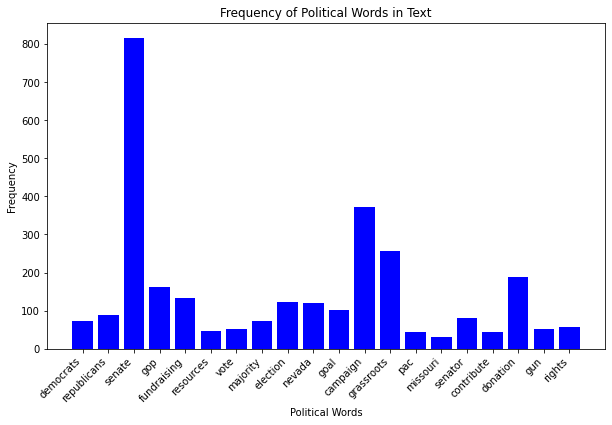

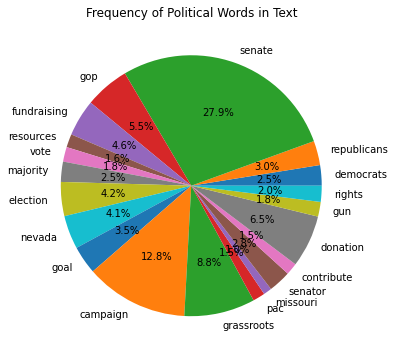

In [22]:
from matplotlib import pyplot as plt

political_words = ['democrats', 'republicans', 'senate', 'gop', 'fundraising', 'resources', 'vote', 'majority', 'election', 'nevada',  'goal', 'campaign', 'grassroots', 'pac', 'missouri', 'senator', 'contribute', 'donation', 'gun', 'rights']

# Load the provided text to scan for these words
text_path = "../data/email_contents_plain.txt"
with open(text_path, 'r', encoding='utf-8') as file:
    str = file.read().lower()  # Convert text to lowercase to match case-insensitively

# Tokenize the text and count the frequency of each political word
from collections import Counter
word_counts = Counter(str.split())
political_word_frequencies = {word: word_counts[word] for word in political_words if word in word_counts}

# Extract words and their frequencies for plotting
words = list(political_word_frequencies.keys())
frequencies = list(political_word_frequencies.values())

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Political Words')
plt.ylabel('Frequency')
plt.title('Frequency of Political Words in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_words_bar_chart.png')
plt.show()
# pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequencies, labels=words, autopct='%1.1f%%')
plt.title('Frequency of Political Words in Text')
# save the pie chart
plt.savefig('../result/political_words_pie_chart.png')
plt.show()

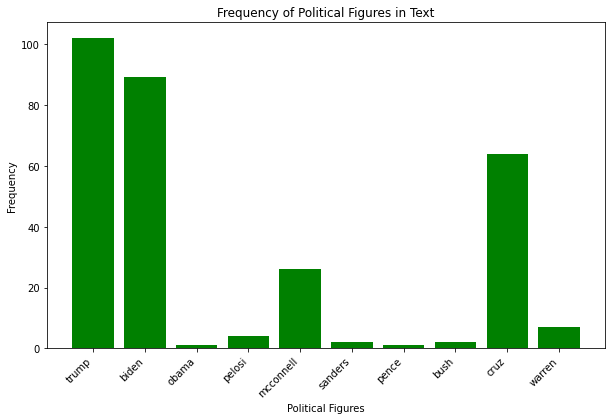

<Figure size 720x432 with 0 Axes>

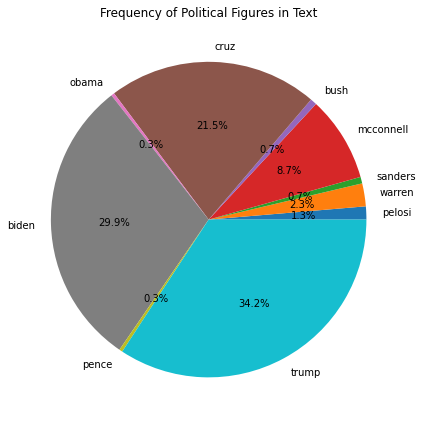

In [23]:
political_figures = ['trump', 'biden', 'obama', 'clinton', 'pelosi', 'mcconnell', 'sanders', 'harris', 'pence', 'romney', 'bush', 'cruz', 'warren', 'soros', 'koch', 'soros', 'koch', 'putin', 'xi', 'kim', 'merkel', 'macron', 'trudeau', 'modi', 'abe', 'erdogan']
political_figures = [figure.lower() for figure in political_figures]
political_figures_frequencies = {figure: word_counts[figure] for figure in political_figures if figure in word_counts}

# Extract figures and their frequencies for plotting
figures = list(political_figures_frequencies.keys())
frequencies = list(political_figures_frequencies.values())

sorted_figures_frequencies = sorted(zip(figures, frequencies), key=lambda x: x[1], reverse=True)

adjusted_figures = []
adjusted_frequencies = []
for i in range(len(sorted_figures_frequencies)):
    if i % 2 == 0:
        adjusted_figures.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 + i//2][0])
        adjusted_frequencies.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 + i//2][1])
    else:
        adjusted_figures.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 - (i//2 + 1)][0])
        adjusted_frequencies.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 - (i//2 + 1)][1])

plt.figure(figsize=(10, 6))
plt.bar(figures, frequencies, color='green')
plt.xlabel('Political Figures')
plt.ylabel('Frequency')
plt.title('Frequency of Political Figures in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_figures_bar_chart.png')
plt.show()
plt.figure(figsize=(10, 6))
# pie chart
plt.figure(figsize=(10, 6))
# plt.pie(frequencies, labels=figures, autopct='%1.1f%%')
plt.pie(adjusted_frequencies, labels=adjusted_figures, autopct='%1.1f%%')
plt.title('Frequency of Political Figures in Text')
plt.tight_layout()
# save the pie chart
plt.savefig('../result/political_figures_pie_chart.png')
plt.show()

TypeError: Axes.pie() missing 1 required positional argument: 'x'

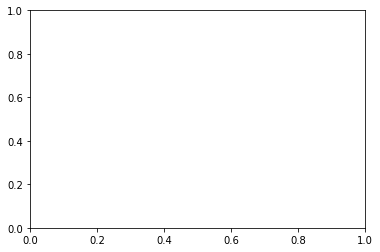

In [25]:
# Count the words, links and images in the HTML content and raw text
html_content = [email['content_html'] for email in emails_all if email['content_html']]
raw_text = [email['content_plain'] for email in emails_all if email['content_plain']]
html_content = ' '.join(html_content)
raw_text = ' '.join(raw_text)

# Count the words, links and images in the HTML content and raw text
from bs4 import BeautifulSoup
bs = BeautifulSoup(html_content, 'html.parser')
html_words = bs.get_text().split()
html_links = [link.get('href') for link in bs.find_all('a', href=True)]
html_images = [image.get('src') for image in bs.find_all('img', src=True)]

# Count the words in the raw text
raw_text_words = raw_text.split()

# Plot them
html_word_count = len(html_words)
raw_text_word_count = len(raw_text_words)
# Merge the word counts
total_word_count = html_word_count + raw_text_word_count

# Create lists for the pie chart
labels = ['HTML Words', 'Raw Text Words']
counts = [html_word_count, raw_text_word_count]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')

# Add a title
ax.set_title('Word Counts in HTML Content and Raw Text')

# save the pie chart
plt.savefig('../result/word_counts_pie_chart.png')
plt.show()

# Merge all words together
all_words = html_words + raw_text_words
all_word_count = len(all_words)

# Count the number of links and images
html_link_count = len(html_links)
html_image_count = len(html_images)

# Create lists for the pie chart
labels = ['Words', 'Links', 'Images']
counts = [all_word_count, html_link_count, html_image_count]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')

# Add a title
ax.set_title('Counts of Words, Links, and Images')

# save the pie chart
plt.savefig('../result/word_link_image_counts_pie_chart.png')
plt.show()